In [1]:
import pandas as pd
from ast import literal_eval
import numpy as np
np.seterr(all="raise")

today = "2019-11-06"

df = pd.read_parquet(f"out/{today}-2d-test.parquet")
df["total_params1"] = df["shape1[0]"] * df["shape1[1]"]
df["total_params2"] = df["shape2[0]"] * df["shape2[1]"]
print(len(df))
df.tail()

73023


,shape1[0],shape2[0],shape1[1],shape2[1],mode,seed,fft_time,direct_time,total_params1,total_params2
73018,74,25,45,50,full,24339,0.000487,0.191245,3330,1250
73019,74,25,45,50,same,24339,0.000532,0.080625,3330,1250
73020,12,8,95,8,valid,24340,0.000313,0.000654,1140,64
73021,12,8,95,8,full,24340,0.000264,0.002489,1140,64
73022,12,8,95,8,same,24340,0.000285,0.001687,1140,64


In [2]:
import sys
sys.path.append("..")
from common import _fftconv_faster_test as _fftconv_faster

In [3]:
def estimate_faster_method(row):
    x_shape = (row["shape1[0]"], row["shape1[1]"])
    h_shape = (row["shape2[0]"], row["shape2[1]"])
    mode = row["mode"]
    return _fftconv_faster(x_shape, h_shape, mode)

In [4]:
fft_faster = df["fft_time"] < df["direct_time"]
df["faster"] = ""
df.loc[fft_faster, "faster"] = "fft"
df.loc[~fft_faster, "faster"] = "direct"

df["faster_est"] = df.apply(estimate_faster_method, axis=1)

acc = (df.faster == df.faster_est).sum() / len(df)
print(f"Predicted fastest method {100 * acc:0.2f}% of the time")

Predicted fastest method 92.16% of the time


In [5]:
df["correct"] = (df.faster == df.faster_est)

**Goal for accuracy on predicting fastest**: >90% -- that's the performance seen with code from SciPy 1.3 (after uncommenting `_get_constant` function above)

In [6]:
df.pivot_table(
    index="mode",
    values="correct",
).reset_index().melt(id_vars=["mode"]).dropna()

,mode,variable,value
0,full,correct,0.944908
1,same,correct,0.914137
2,valid,correct,0.905715


In [7]:
wrong_idx = df.faster != df.faster_est
wrong =  df[wrong_idx].copy()
wrong["ratio"] = wrong.fft_time / wrong.direct_time
idx = wrong.ratio < 1
wrong.loc[idx, "ratio"] = 1 / wrong.loc[idx, "ratio"]

vals = wrong[["mode", "shape1[0]", "shape1[1]", "shape2[0]", "shape2[1]", "ratio", "direct_time", "fft_time"]].copy()
vals.sort_values(by="direct_time", inplace=True)
vals.tail(n=10)

,mode,shape1[0],shape1[1],shape2[0],shape2[1],ratio,direct_time,fft_time
12854,same,493,4,5,10,4.462431,0.001926,0.000432
4574,same,371,22,3,3,4.319306,0.001958,0.000453
57410,same,487,8,5,5,5.751710,0.002005,0.000349
1631,same,493,8,5,5,5.648396,0.002015,0.000357
65951,same,21,423,3,3,4.925926,0.002029,0.000412
60992,same,11,447,3,6,4.926648,0.002050,0.000416
56078,same,20,474,3,3,4.767027,0.002103,0.000441
51299,same,11,487,3,6,6.226955,0.002126,0.000341
23864,same,495,21,3,3,3.827127,0.002328,0.000608
63707,same,477,23,3,3,4.562762,0.002331,0.000511


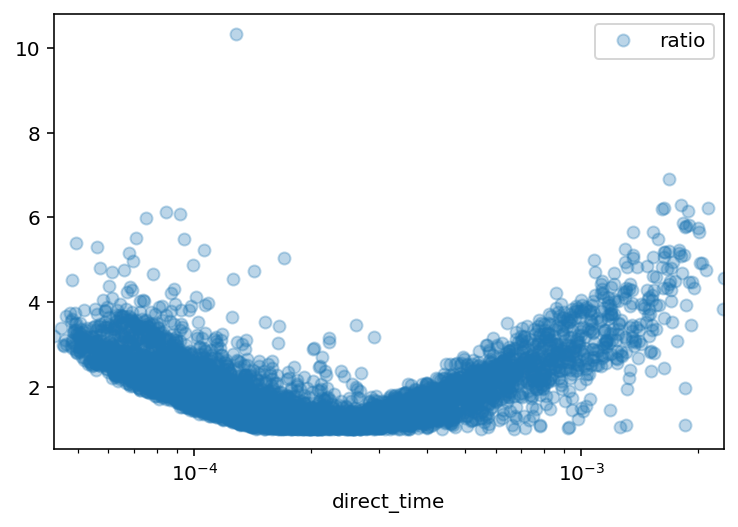

In [9]:
ax = vals[vals.ratio > 0].plot(x="direct_time", y="ratio", style="o", alpha=0.3)
ax.set_xscale("log")

In [10]:
vals.direct_time.min()

-0.03404641151428223

**Goal for this histogram:** `ratio.max() < 5` approximately. That's the performance with SciPy 1.3 (again, after un-commenting `_get_constants` above).

valid a 2295
same a 2090
full a 1341


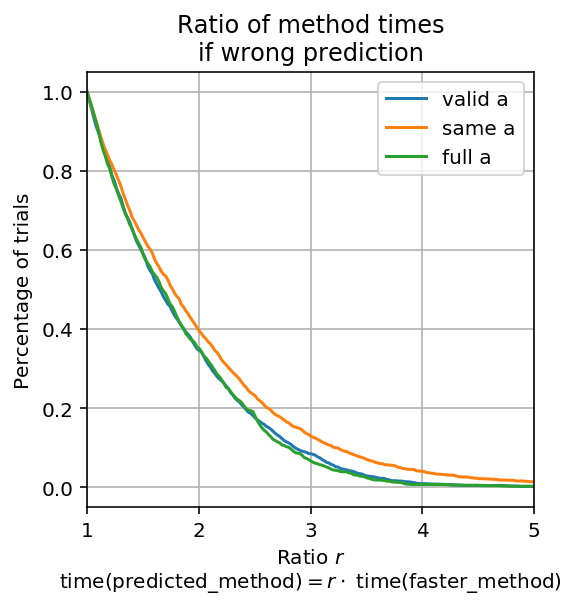

In [36]:
lims = np.linspace(1, int(wrong.ratio.max() + 1), num=500)

import matplotlib.pyplot as plt
w = 4
fig, ax = plt.subplots(figsize=(w, w))
for mode in ["valid", "same", "full"]:
    idx = (wrong["mode"] == mode)# & (wrong["cond"] == cond)
    print(mode, cond, idx.sum())
    show = wrong[(wrong["mode"] == mode)]# & (wrong["cond"] == cond)]
    cdf = {i: (show.ratio <= i).sum() / len(show) for i in lims}
    ax = (1 - pd.Series(cdf)).plot(ax=ax, label=mode + " " + cond)
ax.grid()
ax.legend(loc="best")
# ax.set_yscale("log")
# _ = ax.set_ylim(0.5, 1)
_ = ax.set_title("Ratio of method times\nif wrong prediction")
_ = ax.set_ylabel("Percentage of trials")
_ = ax.set_xlabel("Ratio $r$\n" + r"time(predicted_method)$= r \cdot$ time(faster_method)")
_ = ax.set_xlim(1, 5)
DIR = "/Users/scott/Desktop/"
plt.savefig(DIR + "2d-wrong-factor.png", bbox_inches="tight")

In [33]:
(wrong.ratio <= 5).sum() / len(wrong)

0.9933636046105484

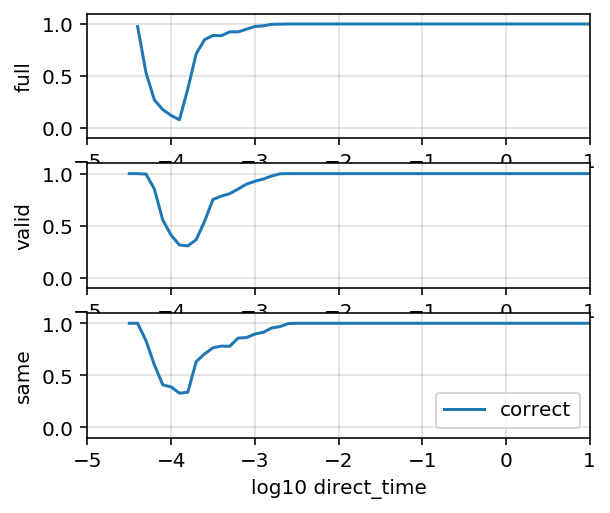

In [35]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode", "direct_time"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)
show["log10(direct_time)_binned"] = np.round(np.log10(show.direct_time), decimals=1)

w = 3
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, 1.3 * w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    correct_predictions = show[show["mode"] == mode].pivot_table(
        index="log10(direct_time)_binned",
        values="correct",
        aggfunc=np.mean
    )
    _ = ax = correct_predictions.plot(ax=ax)
    _ = ax.set_xlim(-5, 1)
    _ = ax.set_ylim(-0.1, 1.1)
#     _ = ax.plot([0, 0], ax.get_ylim())
    _ = ax.set_ylabel(mode)
    _ = ax.grid(alpha=0.4)
    if i == 2:
        ax.set_xlabel("log10 direct_time")
#         ax.text(-3, -0.5, "← FFT faster")
#         ax.text(2, -0.5, "direct faster →")
    else:
        ax.legend_.remove()
plt.savefig(DIR + "2d-direct-time-correct.png", bbox_inches="tight")

FFT >2x faster for 89.35% of tests in mode=full
FFT >2x faster for 76.14% of tests in mode=valid
FFT >2x faster for 82.81% of tests in mode=same


Text(0.5, 0, 'number')

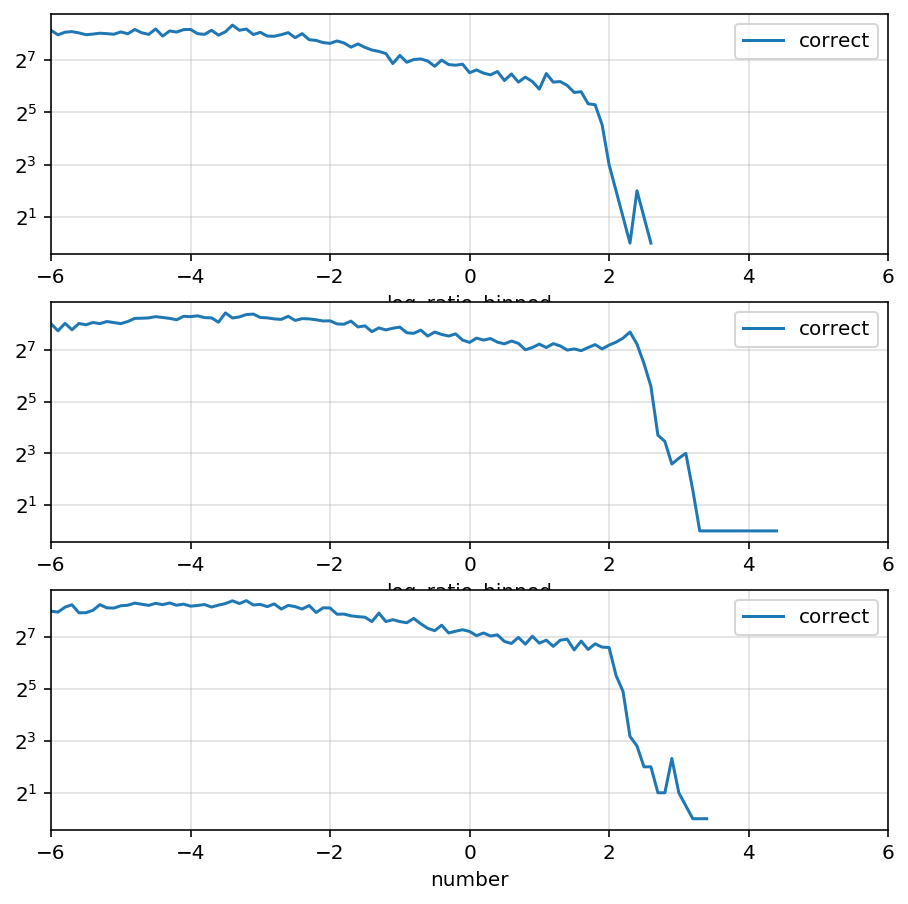

In [13]:
import matplotlib.pyplot as plt

i = (df.direct_time <= 0) | (df.fft_time <= 0)
show = df[~i].copy()
show["log_ratio"] = np.log2(show["fft_time"] / show["direct_time"]);
show = show[["log_ratio", "correct", "mode"]].copy()
show["log_ratio_binned"] = np.round(show.log_ratio, decimals=1)

w = 5
fig, axs = plt.subplots(nrows=3, figsize=(1.5 * w, 1.5 * w))

for i, (ax, mode) in enumerate(zip(axs, ["full", "valid", "same"])):
    s = show[show["mode"] == mode]
    frac_fft_faster = (s.log_ratio < -1).sum() / len(s)
    print(f"FFT >2x faster for {100 * frac_fft_faster:0.2f}% of tests in mode={mode}")
    num = s.pivot_table(
        index="log_ratio_binned",
        values="correct",
        aggfunc=len,
    )
    _ = ax = num.plot(ax=ax)
    ax.set_yscale("log", basey=2)
    _ = ax.set_xlim(-6, 6)
#     _ = ax.set_ylim(-0.1, 1.1)
#     _ = ax.plot([0, 0], ax.get_ylim())
#     _ = ax.set_ylabel(mode)
    _ = ax.grid(alpha=0.4)
    if i == 2:
        ax.set_xlabel("number")
#         ax.text(-3, -0.5, "← FFT faster")
#         ax.text(2, -0.5, "direct faster →")
#     else:
#         ax.legend_.remove()

In [14]:
for i in range(2, 20 + 1):
    prob = (wrong.ratio <= i).sum() / len(wrong)
    msg = f"P(ratio <= {i}) = {100 * prob:0.1f}%"
    print(msg)

P(ratio <= 2) = 63.4%
P(ratio <= 3) = 90.3%
P(ratio <= 4) = 97.9%
P(ratio <= 5) = 99.3%
P(ratio <= 6) = 99.8%
P(ratio <= 7) = 100.0%
P(ratio <= 8) = 100.0%
P(ratio <= 9) = 100.0%
P(ratio <= 10) = 100.0%
P(ratio <= 11) = 100.0%
P(ratio <= 12) = 100.0%
P(ratio <= 13) = 100.0%
P(ratio <= 14) = 100.0%
P(ratio <= 15) = 100.0%
P(ratio <= 16) = 100.0%
P(ratio <= 17) = 100.0%
P(ratio <= 18) = 100.0%
P(ratio <= 19) = 100.0%
P(ratio <= 20) = 100.0%
